<a href="https://colab.research.google.com/github/zhukuixi/Udacity_DataScientistNanoDegree/blob/main/H%26M%20data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',50)

In [104]:
articles = pd.read_csv('/content/drive/MyDrive/H&M_data/data/articles.csv')
customers = pd.read_csv('/content/drive/MyDrive/H&M_data/data/customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/H&M_data/data/transactions_train.csv').sample(100000).reset_index(drop=True)

# Data Visualization


### [Article]:Word Count Barplot Visualization

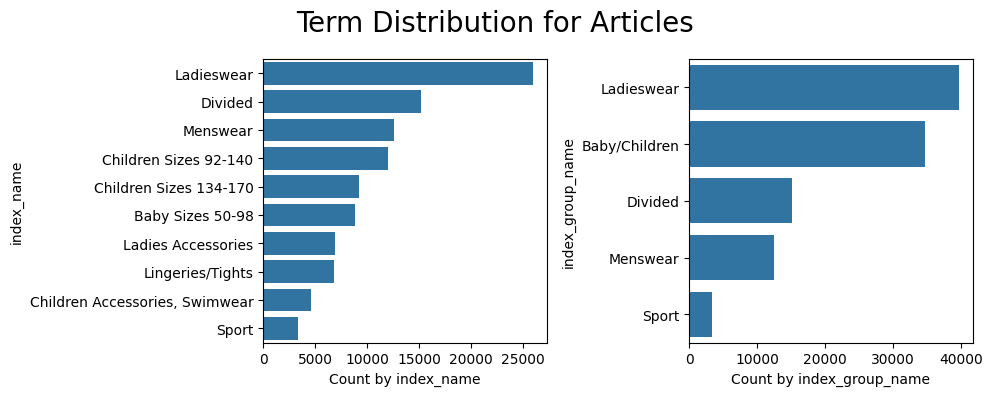

In [105]:
target_col = ['index_name','index_group_name']
fig,ax = plt.subplots(1,len(target_col),figsize=(10,4))
fig.suptitle('Term Distribution for Articles',size=20)
for i in range(len(target_col)):
  feature = target_col[i]
  temp = articles[feature].value_counts().reset_index()
  temp.columns=[feature,'frequency']
  sns.barplot(data=temp,x='frequency',y=feature,ax=ax[i])
  ax[i].set_ylabel(feature)
  ax[i].set_xlabel(f'Count by {feature}')
plt.tight_layout()
plt.show()

In [106]:
plt.figure(1,figsize=(10,10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

## [Customer]: Customer Age Distribution

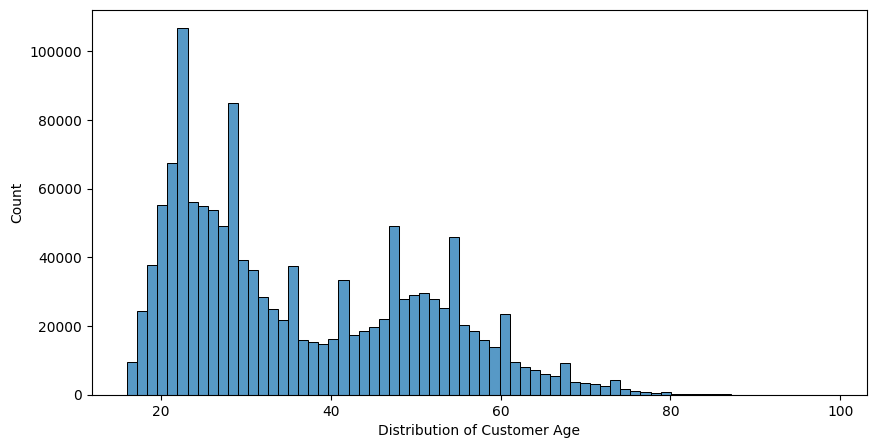

In [107]:
fig,ax = plt.subplots(figsize=(10,5))
sns.histplot(customers['age'],bins=70,ax=ax)
ax.set_xlabel('Distribution of Customer Age')
plt.show()

## [Customer]: Customer Member Status

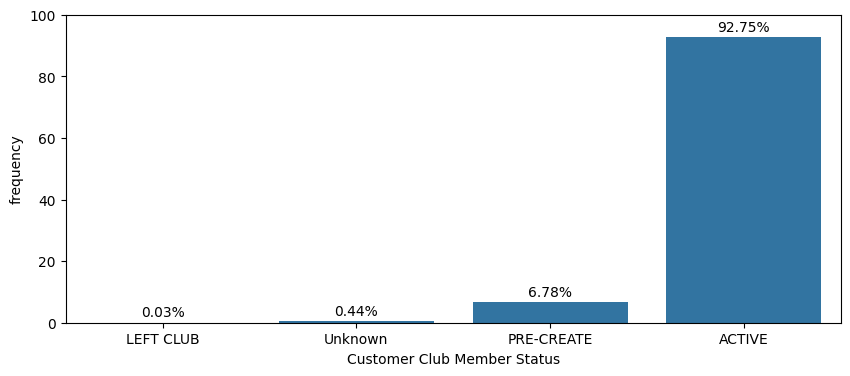

In [108]:
temp = customers['club_member_status'].value_counts(dropna=False).reset_index()
temp.columns=['club member status','frequency']
temp.sort_values('frequency',inplace=True)
temp['club member status'].replace(np.nan,'Unknown',inplace=True)
temp['frequency'] = (100*temp['frequency']/temp['frequency'].sum()).round(2)
fig,ax = plt.subplots(figsize=(10,4))
sns.barplot(data=temp,x='club member status',y='frequency',ax=ax)
ax.set_xlabel('Customer Club Member Status')
ax.set_ylim(0,100)

# Add numbers on top of each bar
for i, v in enumerate(temp['frequency']):
    plt.text(i, v + 1, f'{v}%', ha='center', va='bottom')
plt.show()



## [Transactions]: Transaction Price Ditribution in Different Sale Channel

In [109]:
d1 = transactions.query('sales_channel_id==1')['price']
d2 = transactions.query('sales_channel_id==2')['price']
d3 = transactions['price']

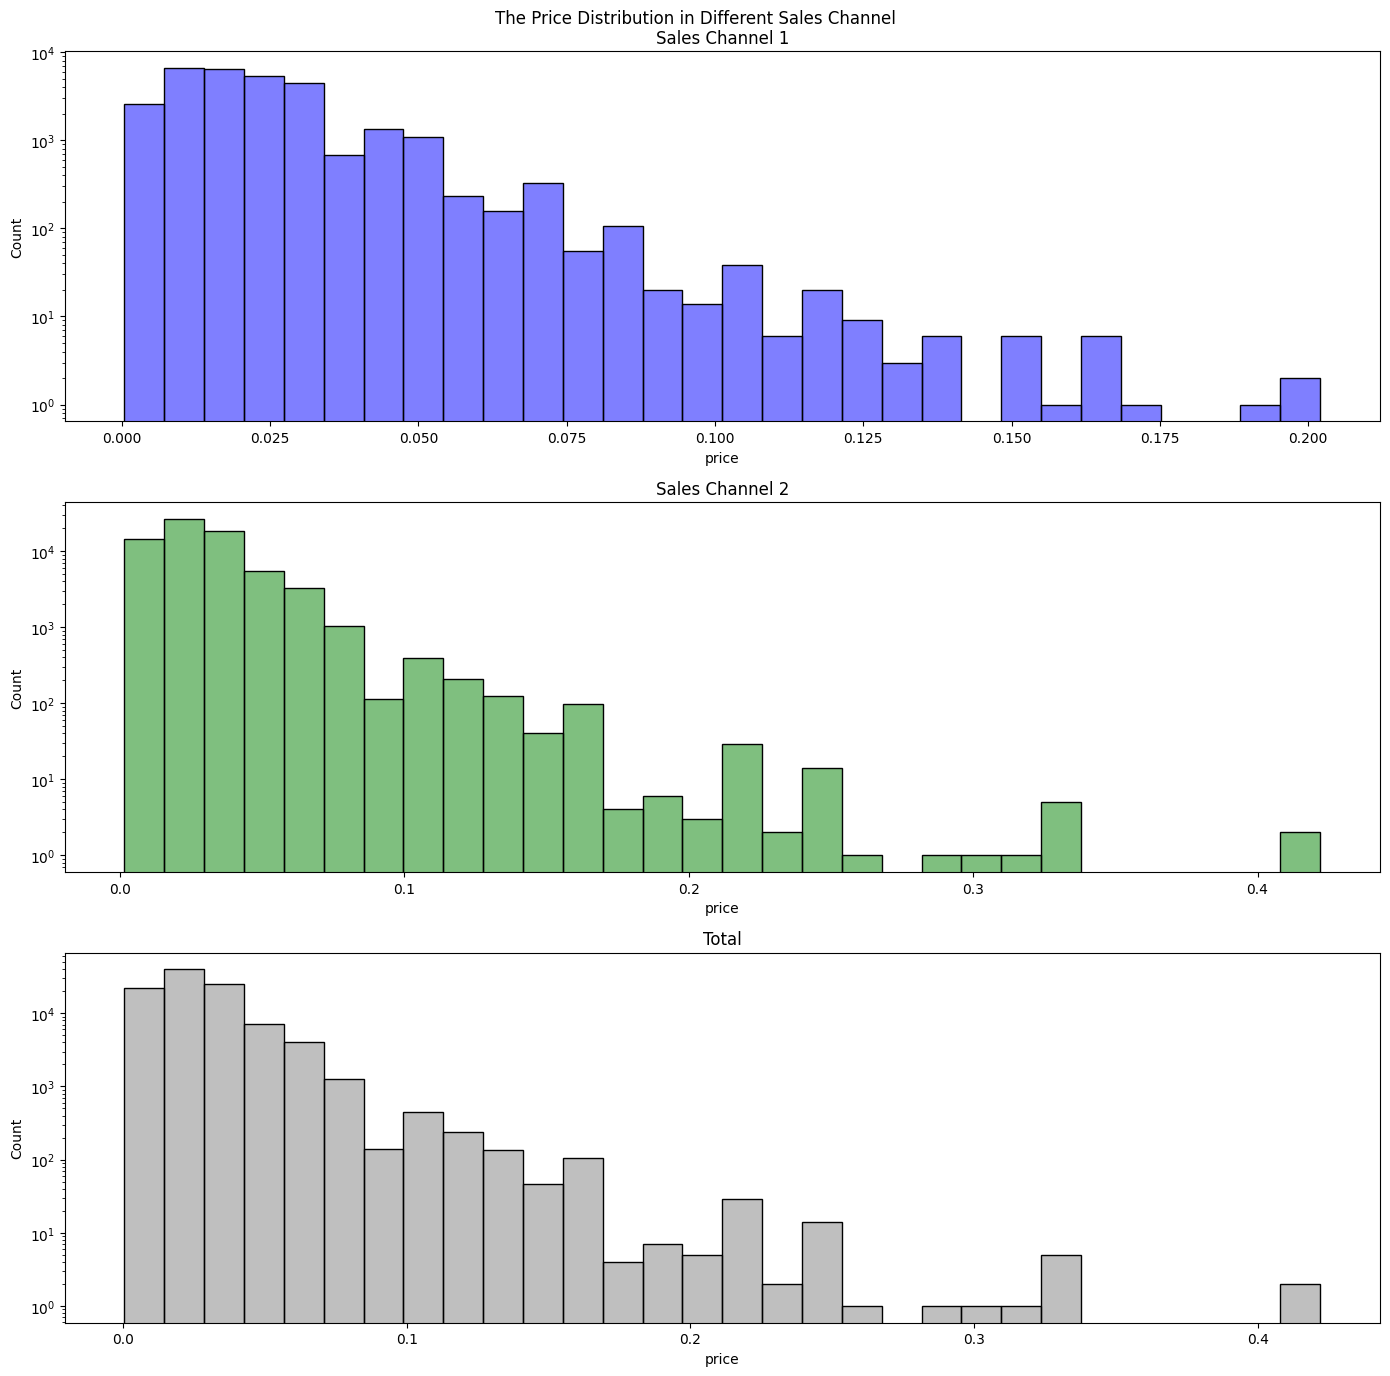

In [110]:
fig,ax = plt.subplots(3,1,figsize=(14,14))
# Sales Channel 1
fig.suptitle('The Price Distribution in Different Sales Channel')
sns.histplot(d1,ax=ax[0],bins=30,alpha=0.5,color='blue')
ax[0].set_title('Sales Channel 1')
ax[0].set_yscale('log')
sns.histplot(d2,ax=ax[1],bins=30,alpha=0.5,color='green')
ax[1].set_title('Sales Channel 2')
ax[1].set_yscale('log')
sns.histplot(d3,ax=ax[2],bins=30,alpha=0.5,color='grey')
ax[2].set_title('Total')
ax[2].set_yscale('log')
plt.tight_layout()
plt.show()

## [Transaction + Article]: Price Trends of Various Products Over Time




In [111]:
article_for_merge = transactions[['customer_id','article_id','price','t_dat']].merge(articles[['article_id','prod_name','product_type_name','product_group_name','index_name']],on='article_id',how='left')
article_for_merge['t_dat'] = pd.to_datetime(article_for_merge['t_dat'])

In [112]:
product_list = ['Shoes','Garment Full body','Bags','Garment Lower body','Underwear']
colors = ['cadetblue','orange','mediumspringgreen','tomato','lightseagreen']

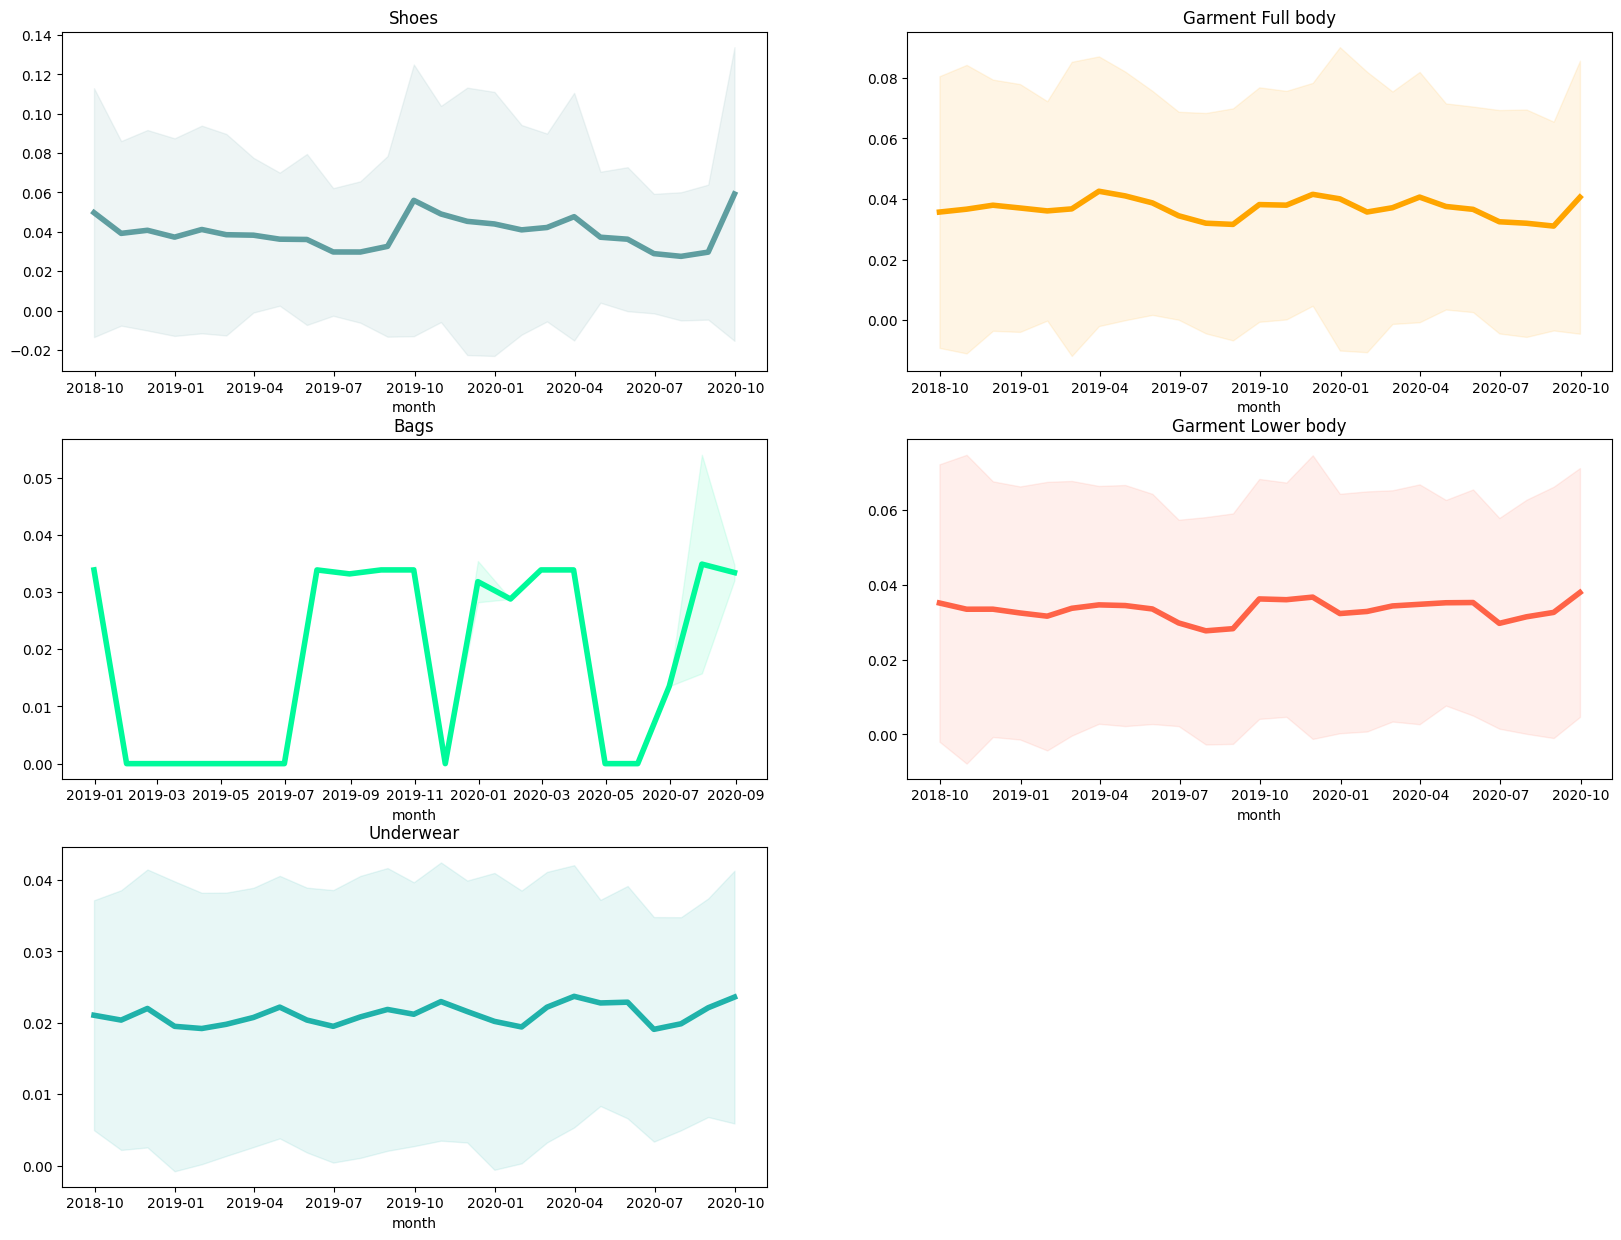

In [113]:
k = 0
f, ax = plt.subplots(3,2,figsize=(20,15))
for i in range(3):
  for j in range(2):
    try:
      product = product_list[k]
      article_for_merge_product = article_for_merge.query('product_group_name==@product')
      result = article_for_merge_product[['t_dat','price']].groupby(pd.Grouper(key='t_dat',freq='M')).agg( \
               mean = ('price','mean'),
                std = ('price','std')
      ).fillna(0)
      ax[i,j].plot(result['mean'],linewidth=4,color=colors[k])
      ax[i,j].fill_between(x=result.index,y1=result['mean']-2*result['std'],y2=result['mean']+2*result['std'],color=colors[k],alpha=0.1)
      ax[i,j].set_title(f'{product}')
      ax[i,j].set_xlabel('month')
      k += 1
    except IndexError:
      ax[i,j].set_visible(False)
plt.show()

##[Transaction]: Daily Transaction Over Time


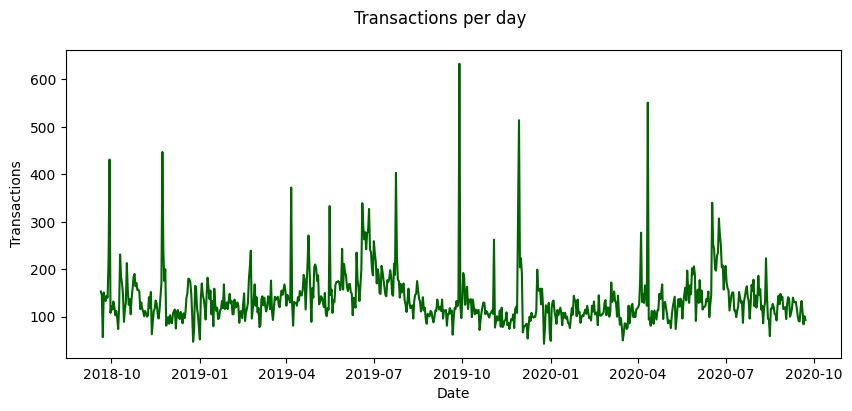

In [114]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
df = transactions.groupby('t_dat')['article_id'].count().reset_index(name='transaction count')
ax.plot(df['t_dat'],df['transaction count'],color='Darkgreen')
ax.set_xlabel('Date')
ax.set_ylabel('Transactions')
plt.suptitle('Transactions per day')
plt.show()

##[Transaction]: Daily Transaction of Differnet Sales Channel Over Time


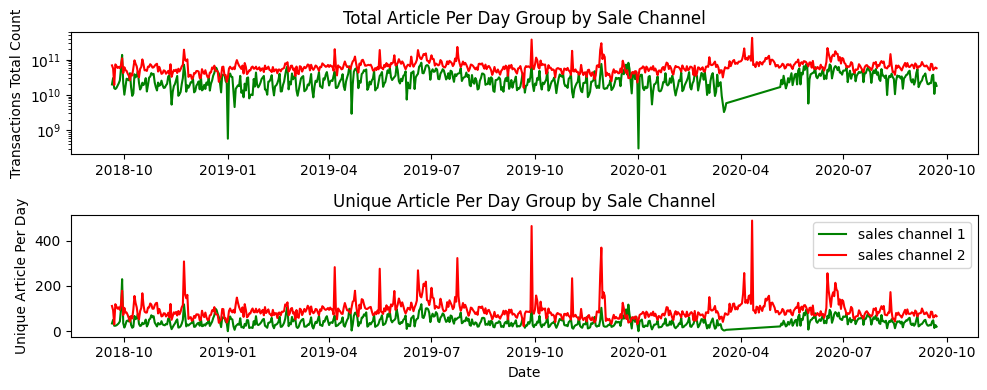

In [115]:
fig, ax = plt.subplots(2,1,figsize=(10,4))
df = transactions.groupby(['t_dat','sales_channel_id']).agg(
                                transaction_count = ('article_id','sum'),
                                transaction_uniqueCount = ('article_id',lambda x:x.nunique()),
                               ).reset_index()

ax[0].plot(df.query('sales_channel_id==1')['t_dat'],df.query('sales_channel_id==1')['transaction_count'],color='green',label='sales channel:1 total sale')
ax[0].plot(df.query('sales_channel_id==2')['t_dat'],df.query('sales_channel_id==2')['transaction_count'],color='red',label='sales channel:2 total sale')
ax[0].set_ylabel('Transactions Total Count')
ax[0].set_title('Total Article Per Day Group by Sale Channel')
ax[0].set_yscale('log')

ax[1].plot(df.query('sales_channel_id==1')['t_dat'],df.query('sales_channel_id==1')['transaction_uniqueCount'],color='green',label='sales channel 1')
ax[1].plot(df.query('sales_channel_id==2')['t_dat'],df.query('sales_channel_id==2')['transaction_uniqueCount'],color='red',label='sales channel 2')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Unique Article Per Day')
ax[1].set_title('Unique Article Per Day Group by Sale Channel')

plt.legend()
plt.tight_layout()
plt.show()

In [116]:
transactions.sales_channel_id.value_counts()

2    70548
1    29452
Name: sales_channel_id, dtype: int64

# Feature Engineering

In [135]:
df = transactions.merge(articles,on='article_id',how='left').merge(customers,on='customer_id',how='left')

## Feature Engineering for Continuous Feature

In [136]:
def num_add(df,f1,f2):
  # add
  df[f'{f1}_add_{f2}'] = df[f1] + df[f2]
  return df

def num_mul(df,f1,f2):
  # mul
  df[f'{f1}_mul_{f2}'] = df[f1] * df[f2]
  return df

def num_div(df,f1,f2):
  # div
  df[f'{f1}_div_{f2}'] = df[f1] / (df[f2] + df[f2].mean())
  return df

def num_log(df,f):
  # add
  df[f'log_{f}'] = np.log(df[f]+1)
  return df

def num_bin(df,f,num_bins=10,bin_type='cut'):
  # bin
  if bin_type=='cut':
    df[f'{f}_bin_{num_bins}'] = pd.cut(df[f],num_bins)
  elif bin_type=='qcut':
    df[f'{f}_bin_{num_bins}'] = pd.qcut(df[f],num_bins)
  return df


In [ ]:
num_bin(df,'age',10,bin_type='qcut')
print(df[['age','age_bin_10']].head())
df.groupby('age_bin_10')['age'].count().head()


In [177]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_enc(df,f):
  # one-hot encoding
  enc = OneHotEncoder()
  transformed_result = enc.fit_transform(df[f].values.reshape(-1,1)).toarray()
  category_cnt = len(enc.categories_[0])
  df[[f'{f}_onehot_{i}' for i in range(category_cnt)]] = transformed_result
  return df

def label_enc(df,f):
  # count encoding
  unique_feature = df[f].unique()
  mapper = dict(zip(unique_feature,range(len(unique_feature))))
  df[f'{f}_label_enc'] = df[f].map(mapper)
  return df

def count_enc(df,f):
  # count encoding
  temp = df[f].value_counts().reset_index(name='cnt')
  mapper = dict(zip(temp.iloc[:,0],temp.iloc[:,1]))
  df[f'{f}_count_enc'] = df[f].map(mapper)
  return df





In [183]:
f = 'perceived_colour_value_name'
count_enc(df,f)
label_enc(df,f)
print(df[[f,f'{f}_count_enc']].head())
print(df[[f,f'{f}_label_enc']].head())


  perceived_colour_value_name  perceived_colour_value_name_count_enc
0                       Light                                  14339
1                        Dark                                  49148
2                       Light                                  14339
3                        Dark                                  49148
4                       Light                                  14339
  perceived_colour_value_name  perceived_colour_value_name_label_enc
0                       Light                                      0
1                        Dark                                      1
2                       Light                                      0
3                        Dark                                      1
4                       Light                                      0


In [173]:
df

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_bin_10,perceived_colour_value_name_onehot_0,perceived_colour_value_name_onehot_1,perceived_colour_value_name_onehot_2,perceived_colour_value_name_onehot_3,perceived_colour_value_name_onehot_4,perceived_colour_value_name_onehot_5,perceived_colour_value_name_onehot_6,perceived_colour_value_name_onehot_7
0,2020-07-15,84309288f36d6b3a63b55883502eee31db372ecce6bf8d...,610776001,0.008458,2,610776,Tilly (1),255,T-shirt,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,T-shirt in lightweight jersey with a rounded h...,NaN,NaN,ACTIVE,NONE,32.0,7155b2c0ef1303b7296b6e76e6396d5634c773cda9ec86...,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2019-04-30,5dc2bb5dceca9e8e6e8ecd63919c3cbf2ca4e0b30f88de...,700079002,0.015814,2,700079,Orvar strap top,253,Vest top,Garment Upper body,1010001,All over pattern,73,Dark Blue,4,Dark,2,Blue,1510,Blouse,A,Ladieswear,1,Ladieswear,6,Womens Casual,1010,Blouses,Top in a crinkled viscose weave with narrow sh...,1.0,1.0,ACTIVE,Regularly,24.0,b05bec617341af92e95cffb76ba2a1bcba2c15f148b591...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-04-14,8b3dc8364c4771865eaa22a2d856af0ead84f51b11c6fc...,778064003,0.007610,2,778064,Claudine t-shirt,255,T-shirt,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Fitted top in soft organic cotton jersey with ...,NaN,NaN,ACTIVE,NONE,29.0,8b771f0e072a2485104c97abbb760a9319592c19adfb66...,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2018-09-20,e186d835ef5e8f6d085684adf3b2dad8f6856362c5167b...,657291004,0.010153,2,657291,Dawn magnolia thong,286,Underwear bottom,Underwear,1010016,Solid,53,Dark Pink,4,Dark,18,Red,1338,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear",Thong briefs in microfibre and mesh with a low...,NaN,NaN,ACTIVE,NONE,45.0,d9175393f25578bfb8fa9828d10b6a906396c66bcc39d4...,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-03-01,f7f2b6ccf2a20b2b173281a35012d202416954b629bdfd...,620221007,0.064390,2,620221,Elsa printed trousers,272,Trousers,Garment Lower body,1010001,All over pattern,10,White,3,Light,9,White,1948,Trousers & Skirt,A,Ladieswear,1,Ladieswear,18,Womens Trend,1009,Trousers,"Wide, high-waisted trousers in a patterned wea...",NaN,NaN,PRE-CREATE,NONE,59.0,faee2628ea621e5808465f0074721b94a1df9123e665ec...,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2020-05-09,560b09162e9fc4acd61c53734c72af4378dbad37266851...,877014008,0.029203,2,877014,Kiwi,265,Dress,Garment Full body,1010016,Solid,10,White,3,Light,9,White,1322,Dress,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1013,Dresses Ladies,"Calf-length, A-line dress in an airy weave. V-...",NaN,NaN,ACTIVE,NONE,24.0,f181eeeb97ef8bfbb22188a1900ece504ba7df84df0abd...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
99996,2018-12-20,0c7926801908cdbd4d0060b12b7c9c7127e92ab216deed...,713321001,0.022017,2,713321,MANFRED BATWING CREW,252,Sweater,Garment Upper body,1010010,Melange,7,Grey,1,Dusty Light,12,Grey,1660,Jersey,A,Ladieswear,1,Ladieswear,6,Womens Casual,1005,Jersey Fancy,Top in lightweight sweatshirt fabric with low ...,NaN,NaN,ACTIVE,NONE,24.0,d580d7113007e808f856ef29849cb40d8f83917eed04b5...,1.